In [137]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, HTML


<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>

In [138]:
# data downloaded from NASA:
# https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# and stored in directory cmapsdata

#bunch of setup
%matplotlib inline
#sns.set()
inputdir = "cmapsdata" 

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [3]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'/train_FD001.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'/test_FD001.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
0               1      1       -0.0007       -0.0004         100.0    518.67   
1               1      2        0.0019       -0.0003         100.0    518.67   
2               1      3       -0.0043        0.0003         100.0    518.67   
3               1      4        0.0007        0.0000         100.0    518.67   
4               1      5       -0.0019       -0.0002         100.0    518.67   
...           ...    ...           ...           ...           ...       ...   
20626         100    196       -0.0004       -0.0003         100.0    518.67   
20627         100    197       -0.0016       -0.0005         100.0    518.67   
20628         100    198        0.0004        0.0000         100.0    518.67   
20629         100    199       -0.0011        0.0003         100.0    518.67   
20630         100    200       -0.0032       -0.0005         100.0    518.67   

       Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_12  Sensor_13  \
0        641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1        642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2        642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3        642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4        642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   
...         ...       ...       ...       ...  ...        ...        ...   
20626    643.49   1597.98   1428.63     14.62  ...     519.49    2388.26   
20627    643.54   1604.50   1433.58     14.62  ...     519.68    2388.22   
20628    643.42   1602.46   1428.18     14.62  ...     520.01    2388.24   
20629    643.23   1605.26   1426.53     14.62  ...     519.67    2388.23   
20630    643.85   1600.38   1432.14     14.62  ...     519.30    2388.26   

       Sensor_14  Sensor_15  Sensor_16  Sensor_17  Sensor_18  Sensor_19  \
0        8138.62     8.4195       0.03        392       2388      100.0   
1        8131.49     8.4318       0.03        392       2388      100.0   
2        8133.23     8.4178       0.03        390       2388      100.0   
3        8133.83     8.3682       0.03        392       2388      100.0   
4        8133.80     8.4294       0.03        393       2388      100.0   
...          ...        ...        ...        ...        ...        ...   
20626    8137.60     8.4956       0.03        397       2388      100.0   
20627    8136.50     8.5139       0.03        395       2388      100.0   
20628    8141.05     8.5646       0.03        398       2388      100.0   
20629    8139.29     8.5389       0.03        395       2388      100.0   
20630    8137.33     8.5036       0.03        396       2388      100.0   

       Sensor_20  Sensor_21  
0          39.06    23.4190  
1          39.00    23.4236  
2          38.95    23.3442  
3          38.88    23.3739  
4          38.90    23.4044  
...          ...        ...  
20626      38.49    22.9735  
20627      38.30    23.1594  
20628      38.44    22.9333  
20629      38.29    23.0640  
20630      38.37    23.0522  

[20631 rows x 26 columns]

# Computing RUL and flagging all failure cases in the training set

In [25]:
#count cycle time
df_train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle = df_train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

# merge the max cycle back into the original frame
train_merged = df_train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

# calculate RUL for each row
Target_RUL = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_RUL"] = Target_RUL

# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

# flag failures
train_with_target["IsFailure"] = 1*(train_with_target['Target_RUL'] == 0)

#show the table
display(train_with_target)

UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
0               1      1       -0.0007       -0.0004         100.0    518.67   
1               1      2        0.0019       -0.0003         100.0    518.67   
2               1      3       -0.0043        0.0003         100.0    518.67   
3               1      4        0.0007        0.0000         100.0    518.67   
4               1      5       -0.0019       -0.0002         100.0    518.67   
...           ...    ...           ...           ...           ...       ...   
20626         100    196       -0.0004       -0.0003         100.0    518.67   
20627         100    197       -0.0016       -0.0005         100.0    518.67   
20628         100    198        0.0004        0.0000         100.0    518.67   
20629         100    199       -0.0011        0.0003         100.0    518.67   
20630         100    200       -0.0032       -0.0005         100.0    518.67   

       Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_14  Sensor_15  \
0        641.82   1589.70   1400.60     14.62  ...    8138.62     8.4195   
1        642.15   1591.82   1403.14     14.62  ...    8131.49     8.4318   
2        642.35   1587.99   1404.20     14.62  ...    8133.23     8.4178   
3        642.35   1582.79   1401.87     14.62  ...    8133.83     8.3682   
4        642.37   1582.85   1406.22     14.62  ...    8133.80     8.4294   
...         ...       ...       ...       ...  ...        ...        ...   
20626    643.49   1597.98   1428.63     14.62  ...    8137.60     8.4956   
20627    643.54   1604.50   1433.58     14.62  ...    8136.50     8.5139   
20628    643.42   1602.46   1428.18     14.62  ...    8141.05     8.5646   
20629    643.23   1605.26   1426.53     14.62  ...    8139.29     8.5389   
20630    643.85   1600.38   1432.14     14.62  ...    8137.33     8.5036   

       Sensor_16  Sensor_17  Sensor_18  Sensor_19  Sensor_20  Sensor_21  \
0           0.03        392       2388      100.0      39.06    23.4190   
1           0.03        392       2388      100.0      39.00    23.4236   
2           0.03        390       2388      100.0      38.95    23.3442   
3           0.03        392       2388      100.0      38.88    23.3739   
4           0.03        393       2388      100.0      38.90    23.4044   
...          ...        ...        ...        ...        ...        ...   
20626       0.03        397       2388      100.0      38.49    22.9735   
20627       0.03        395       2388      100.0      38.30    23.1594   
20628       0.03        398       2388      100.0      38.44    22.9333   
20629       0.03        395       2388      100.0      38.29    23.0640   
20630       0.03        396       2388      100.0      38.37    23.0522   

       Target_RUL  IsFailure  
0             191          0  
1             190          0  
2             189          0  
3             188          0  
4             187          0  
...           ...        ...  
20626           4          0  
20627           3          0  
20628           2          0  
20629           1          0  
20630           0          1  

[20631 rows x 28 columns]

We can now easily collect the features of failure cases in the training set

In [26]:
display(train_with_target[train_with_target['IsFailure'] == True])

UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
191             1    192        0.0009       -0.0000         100.0    518.67   
478             2    287       -0.0005        0.0006         100.0    518.67   
657             3    179        0.0012        0.0000         100.0    518.67   
846             4    189       -0.0024       -0.0002         100.0    518.67   
1115            5    269        0.0022        0.0003         100.0    518.67   
...           ...    ...           ...           ...           ...       ...   
19887          96    336       -0.0031       -0.0005         100.0    518.67   
20089          97    202        0.0014        0.0001         100.0    518.67   
20245          98    156        0.0077       -0.0003         100.0    518.67   
20430          99    185       -0.0019       -0.0004         100.0    518.67   
20630         100    200       -0.0032       -0.0005         100.0    518.67   

       Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_14  Sensor_15  \
191      643.54   1601.41   1427.20     14.62  ...    8110.93     8.5113   
478      643.85   1608.50   1430.84     14.62  ...    8175.57     8.5365   
657      643.51   1604.80   1428.23     14.62  ...    8255.34     8.5056   
846      644.53   1612.11   1432.55     14.62  ...    8259.42     8.5246   
1115     643.46   1597.28   1430.74     14.62  ...    8212.75     8.5209   
...         ...       ...       ...       ...  ...        ...        ...   
19887    643.74   1599.20   1432.12     14.62  ...    8144.03     8.5022   
20089    643.79   1610.66   1427.41     14.62  ...    8263.63     8.5277   
20245    643.02   1603.77   1432.16     14.62  ...    8122.22     8.5308   
20430    643.93   1598.42   1421.56     14.62  ...    8127.53     8.5425   
20630    643.85   1600.38   1432.14     14.62  ...    8137.33     8.5036   

       Sensor_16  Sensor_17  Sensor_18  Sensor_19  Sensor_20  Sensor_21  \
191         0.03        396       2388      100.0      38.48    22.9649   
478         0.03        398       2388      100.0      38.43    23.0848   
657         0.03        398       2388      100.0      38.40    22.9562   
846         0.03        398       2388      100.0      38.44    23.1006   
1115        0.03        397       2388      100.0      38.45    23.0296   
...          ...        ...        ...        ...        ...        ...   
19887       0.03        397       2388      100.0      38.36    23.0258   
20089       0.03        397       2388      100.0      38.29    23.1184   
20245       0.03        396       2388      100.0      38.33    23.1137   
20430       0.03        397       2388      100.0      38.49    23.1931   
20630       0.03        396       2388      100.0      38.37    23.0522   

       Target_RUL  IsFailure  
191             0          1  
478             0          1  
657             0          1  
846             0          1  
1115            0          1  
...           ...        ...  
19887           0          1  
20089           0          1  
20245           0          1  
20430           0          1  
20630           0          1  

[100 rows x 28 columns]

Let's first visualize failure and non-failure cases. 

We will use PCA to reduce the dimension and then plot the failure cases, which shall help in the future path of this study.

In [27]:
#let's build feature set X and label Y
to_drop = ['UnitNumber', 'Cycle', 'Target_RUL', 'IsFailure']  
X = train_with_target.drop(to_drop, axis = 1)
Y = train_with_target['IsFailure']

# Dimensionality Reduction with PCA

Let's try PCA with 10 components just to see how much variance we can capture. First we fit the feature data

In [28]:
pca_comp = 10
pca = PCA(n_components=pca_comp)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

... then let's see the variance explained.

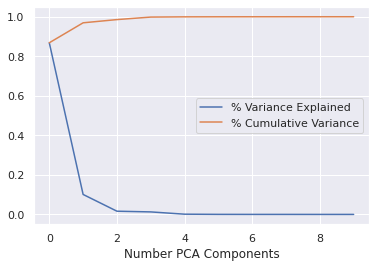

In [29]:
pca_var = pca.explained_variance_/pca.explained_variance_.sum()
pca_cumsum = pca_var.cumsum()

plt.plot(np.arange(pca_comp), pca_var, label="% Variance Explained")
plt.plot(np.arange(pca_comp), pca_cumsum, label="% Cumulative Variance")
plt.xlabel("Number PCA Components")
plt.legend()
plt.show()

Quite good. Let us much reduced dimension for visualization purposes.
Let us use PCA with `n_comp = 2`, transform the feature, and plot with the label.

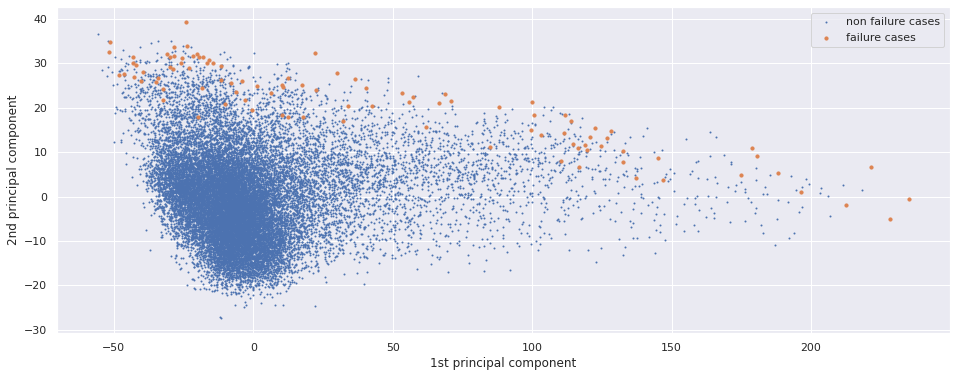

In [9]:
#fit PCA with 2 components
pca_comp = 2
pca = PCA(n_components=pca_comp)
pca.fit(X)

#transform feature with this model
X_pca = pca.transform(X)

#distinguish features based on label
X_failures = X_pca[Y, :]
X_nonfailures = X_pca[~Y, :]

#plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(X_nonfailures[:,0], X_nonfailures[:,1], s=1, label="non failure cases")
ax.scatter(X_failures[:,0], X_failures[:,1], s=10, label="failure cases")
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.legend()
plt.show()

Not bad, the failure cases seems to have some sort of pattern in this two dimensional principal component space. 
What's next?

---

Think of ways to extract the trend for machine and trying to predict the probability of failure, given a set of feature (hint: classification algorithm). 

Another way to approach this is to try to predict what is the RUL, given a set of feature (hint: regression. see e.g. [Kaggle](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot/)).

Note: We have not implemented any time series analyses yet. We can do that, in fact, that might be a superior approach. We can first extract the trend while also analysing the variance. Then our goal might be to predict what is the optimal predictive maintenance strategy (optimal in the sense it balances risk and maintenance cost, or something like that). Cheers!

--- 

We want to predict the probability of failure given the whole trajectory up to the current point $P(Y=1|X_{0:t})$

Our target to set a threshold when an action needed to be taken




In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

In [76]:
cut_off = 200
train_censored = train_with_target[train_with_target['Cycle'] <= cut_off].copy()
train_censored['CycleStart'] = train_censored['Cycle'] - 1
drop_sensors = op_settings_columns + ['Target_RUL'] +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = train_censored.drop(labels=drop_sensors, axis=1)
X

UnitNumber  Cycle  Sensor_2  Sensor_3  Sensor_4  Sensor_7  Sensor_8  \
0               1      1    641.82   1589.70   1400.60    554.36   2388.06   
1               1      2    642.15   1591.82   1403.14    553.75   2388.04   
2               1      3    642.35   1587.99   1404.20    554.26   2388.08   
3               1      4    642.35   1582.79   1401.87    554.45   2388.11   
4               1      5    642.37   1582.85   1406.22    554.00   2388.06   
...           ...    ...       ...       ...       ...       ...       ...   
20626         100    196    643.49   1597.98   1428.63    551.43   2388.19   
20627         100    197    643.54   1604.50   1433.58    550.86   2388.23   
20628         100    198    643.42   1602.46   1428.18    550.94   2388.24   
20629         100    199    643.23   1605.26   1426.53    550.68   2388.25   
20630         100    200    643.85   1600.38   1432.14    550.79   2388.26   

       Sensor_9  Sensor_11  Sensor_12  Sensor_13  Sensor_14  Sensor_15  \
0       9046.19      47.47     521.66    2388.02    8138.62     8.4195   
1       9044.07      47.49     522.28    2388.07    8131.49     8.4318   
2       9052.94      47.27     522.42    2388.03    8133.23     8.4178   
3       9049.48      47.13     522.86    2388.08    8133.83     8.3682   
4       9055.15      47.28     522.19    2388.04    8133.80     8.4294   
...         ...        ...        ...        ...        ...        ...   
20626   9065.52      48.07     519.49    2388.26    8137.60     8.4956   
20627   9065.11      48.04     519.68    2388.22    8136.50     8.5139   
20628   9065.90      48.09     520.01    2388.24    8141.05     8.5646   
20629   9073.72      48.39     519.67    2388.23    8139.29     8.5389   
20630   9061.48      48.20     519.30    2388.26    8137.33     8.5036   

       Sensor_17  Sensor_20  Sensor_21  IsFailure  CycleStart  
0            392      39.06    23.4190          0           0  
1            392      39.00    23.4236          0           1  
2            390      38.95    23.3442          0           2  
3            392      38.88    23.3739          0           3  
4            393      38.90    23.4044          0           4  
...          ...        ...        ...        ...         ...  
20626        397      38.49    22.9735          0         195  
20627        395      38.30    23.1594          0         196  
20628        398      38.44    22.9333          0         197  
20629        395      38.29    23.0640          0         198  
20630        396      38.37    23.0522          1         199  

[18627 rows x 18 columns]

In [42]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'IsFailure'
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -63.86
  time fit was run = 2021-01-29 21:42:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    2.05       7.75       0.72             0.64             3.45                 1.90                31.64
Sensor_3    0.07       1.07       0.04            -0.01             0.15                 0.99                 1.16
Sensor_4    0.16       1.18       0.05             0.07             0.26                 1.07                 1.29
Sensor_7   -1.09       0.34       0.50            -2.07            -0.11                 0.13                 0.90
Sensor_8   -5.03       0.01       4.84           -14.51             4.45                 0.00                85.78
Sensor_9   -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
Sensor_11   5.12     167.43       1.70             1.78             8.46                 5.95              4714.92
Sensor_12  -1.14       0.32       0.53            -2.17            -0.10                 0.11                 0.90
Sensor_13  12.90   3.99e+05       5.51             2.09            23.70                 8.09             1.97e+10
Sensor_14   0.04       1.04       0.04            -0.04             0.12                 0.96                 1.13
Sensor_15   5.07     159.96       9.53           -13.61            23.76                 0.00             2.09e+10
Sensor_17   0.41       1.51       0.20             0.01             0.81                 1.01                 2.25
Sensor_20  -5.13       0.01       2.02            -9.09            -1.17                 0.00                 0.31
Sensor_21  -4.23       0.01       2.67            -9.46             1.01                 0.00                 2.75

              z      p   -log2(p)
covariate                        
Sensor_2   2.85 <0.005       7.84
Sensor_3   1.73   0.08       3.57
Sensor_4   3.49 <0.005      11.03
Sensor_7  -2.17   0.03       5.06
Sensor_8  -1.04   0.30       1.74
Sensor_9  -0.58   0.56       0.82
Sensor_11  3.01 <0.005       8.56
Sensor_12 -2.15   0.03       4.99
Sensor_13  2.34   0.02       5.69
Sensor_14  0.95   0.34       1.54
Sensor_15  0.53   0.59       0.75
Sensor_17  2.03   0.04       4.56
Sensor_20 -2.54   0.01       6.49
Sensor_21 -1.58   0.11       3.14
---
Partial AIC = 155.72
log-likelihood ratio test = 333.85 on 14 df
-log2(p) of ll-ratio test = 205.97

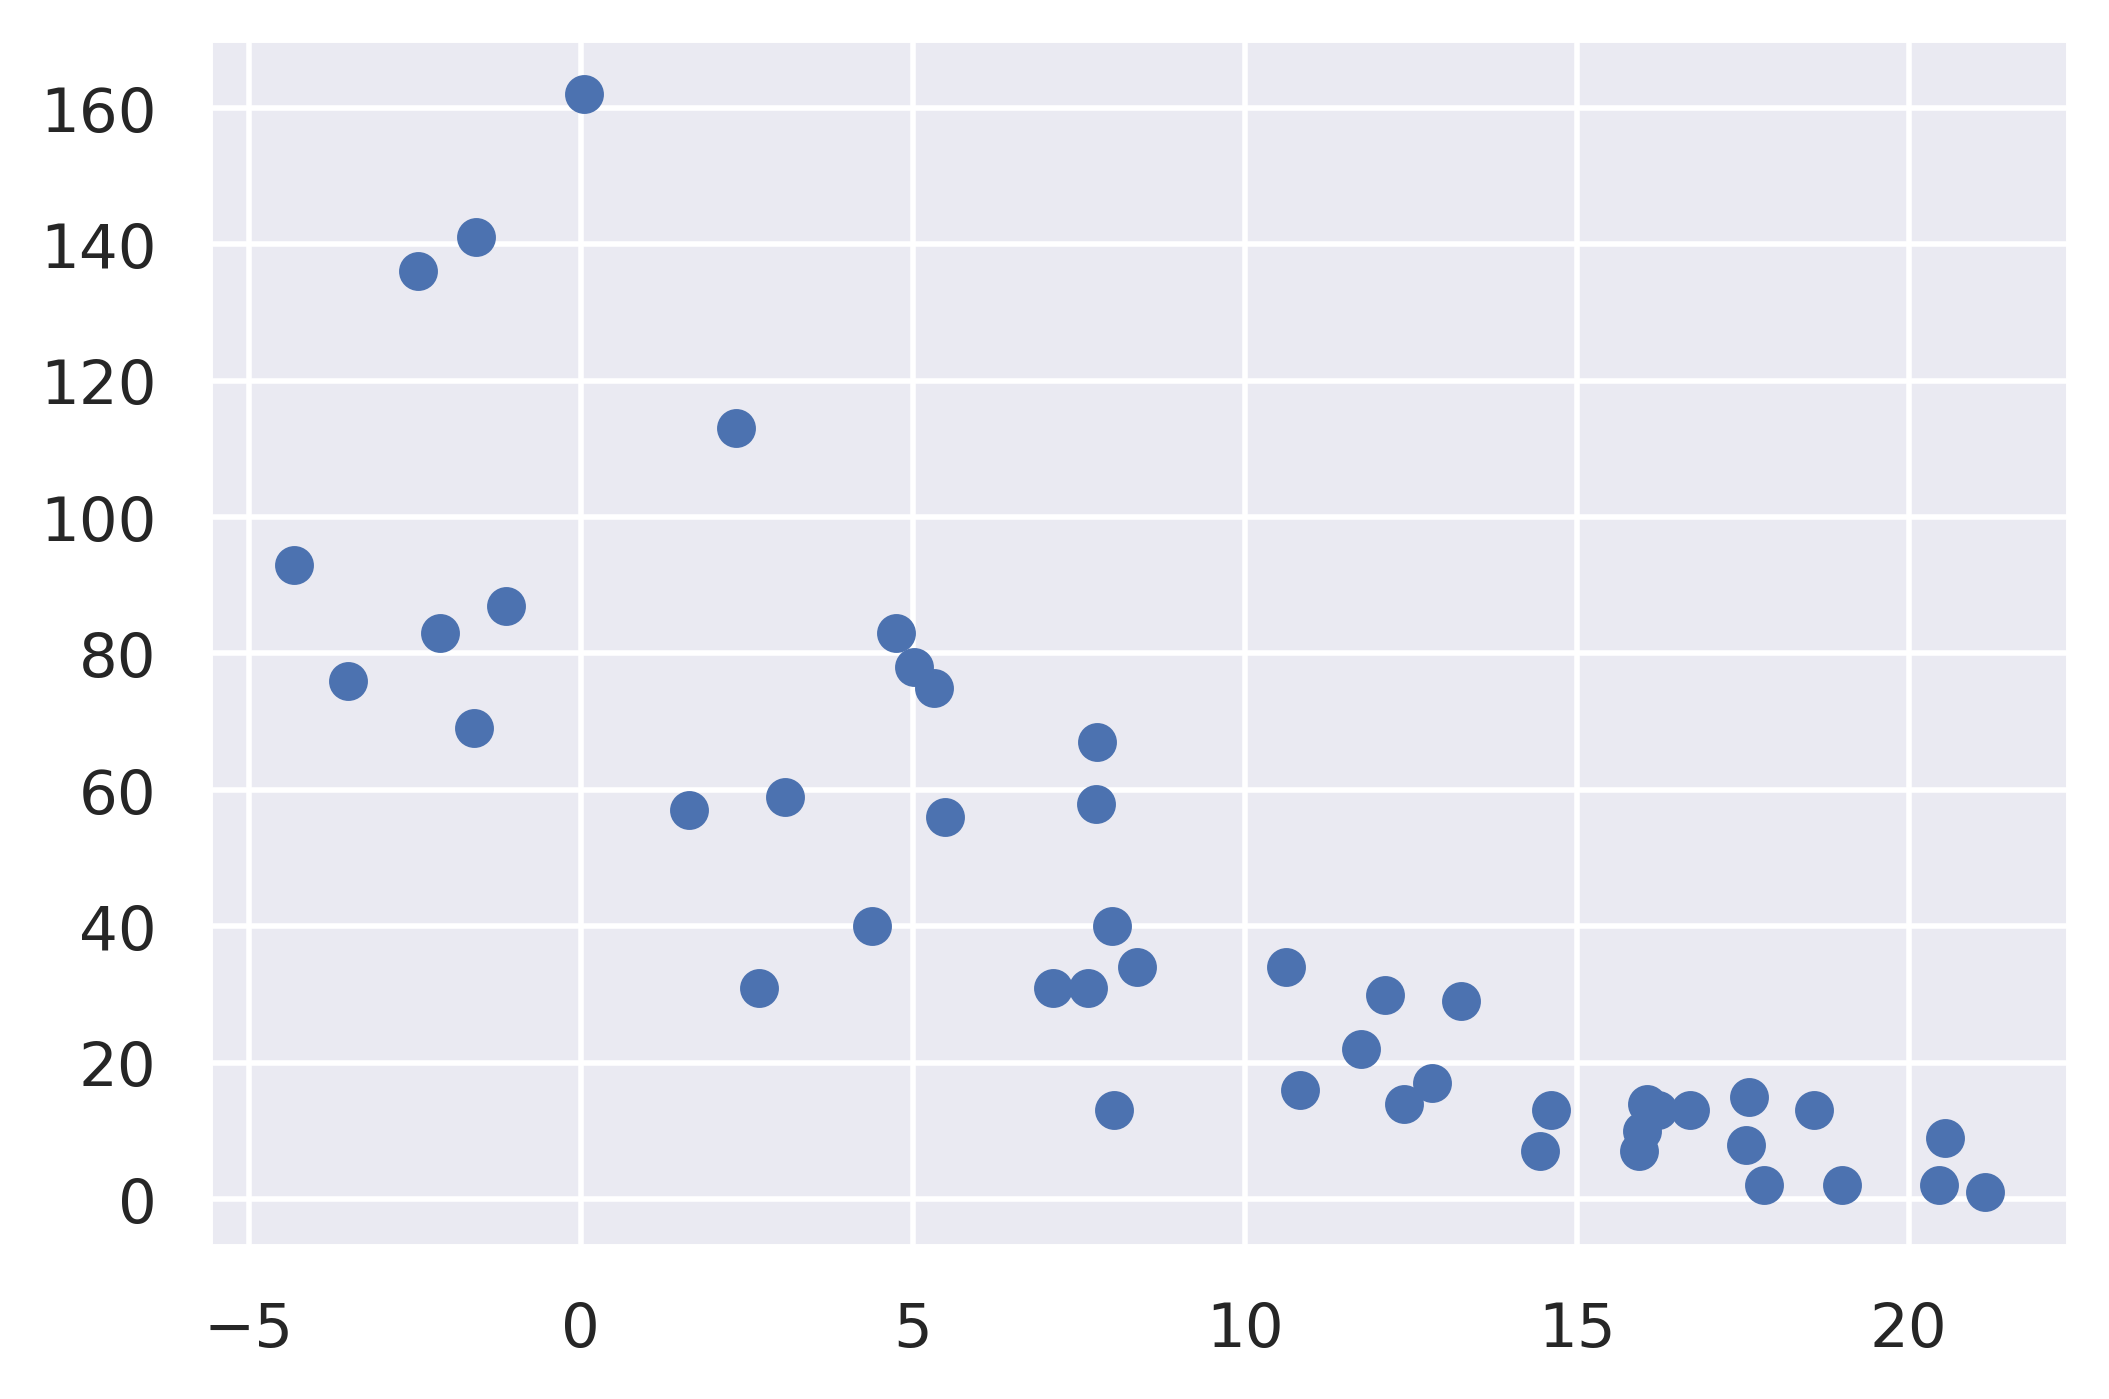

In [141]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']


test_df = train_censored.groupby("UnitNumber").last()
test_df = test_df[test_df['IsFailure']==0]
df_last = train_censored.groupby("UnitNumber").last()
pred = cph.predict_log_partial_hazard(test_df[pred_cols])
pred = pd.DataFrame(pred, columns=['LogPartialHazard'])
pred['UnitNumber'] = test_df.index
pred.set_index('UnitNumber', inplace=True)
pred['Target_RUL'] = test_df['Target_RUL']
pred


plt.figure(dpi=400)
plt.scatter(pred['LogPartialHazard'], pred['Target_RUL'])
plt.show()

/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


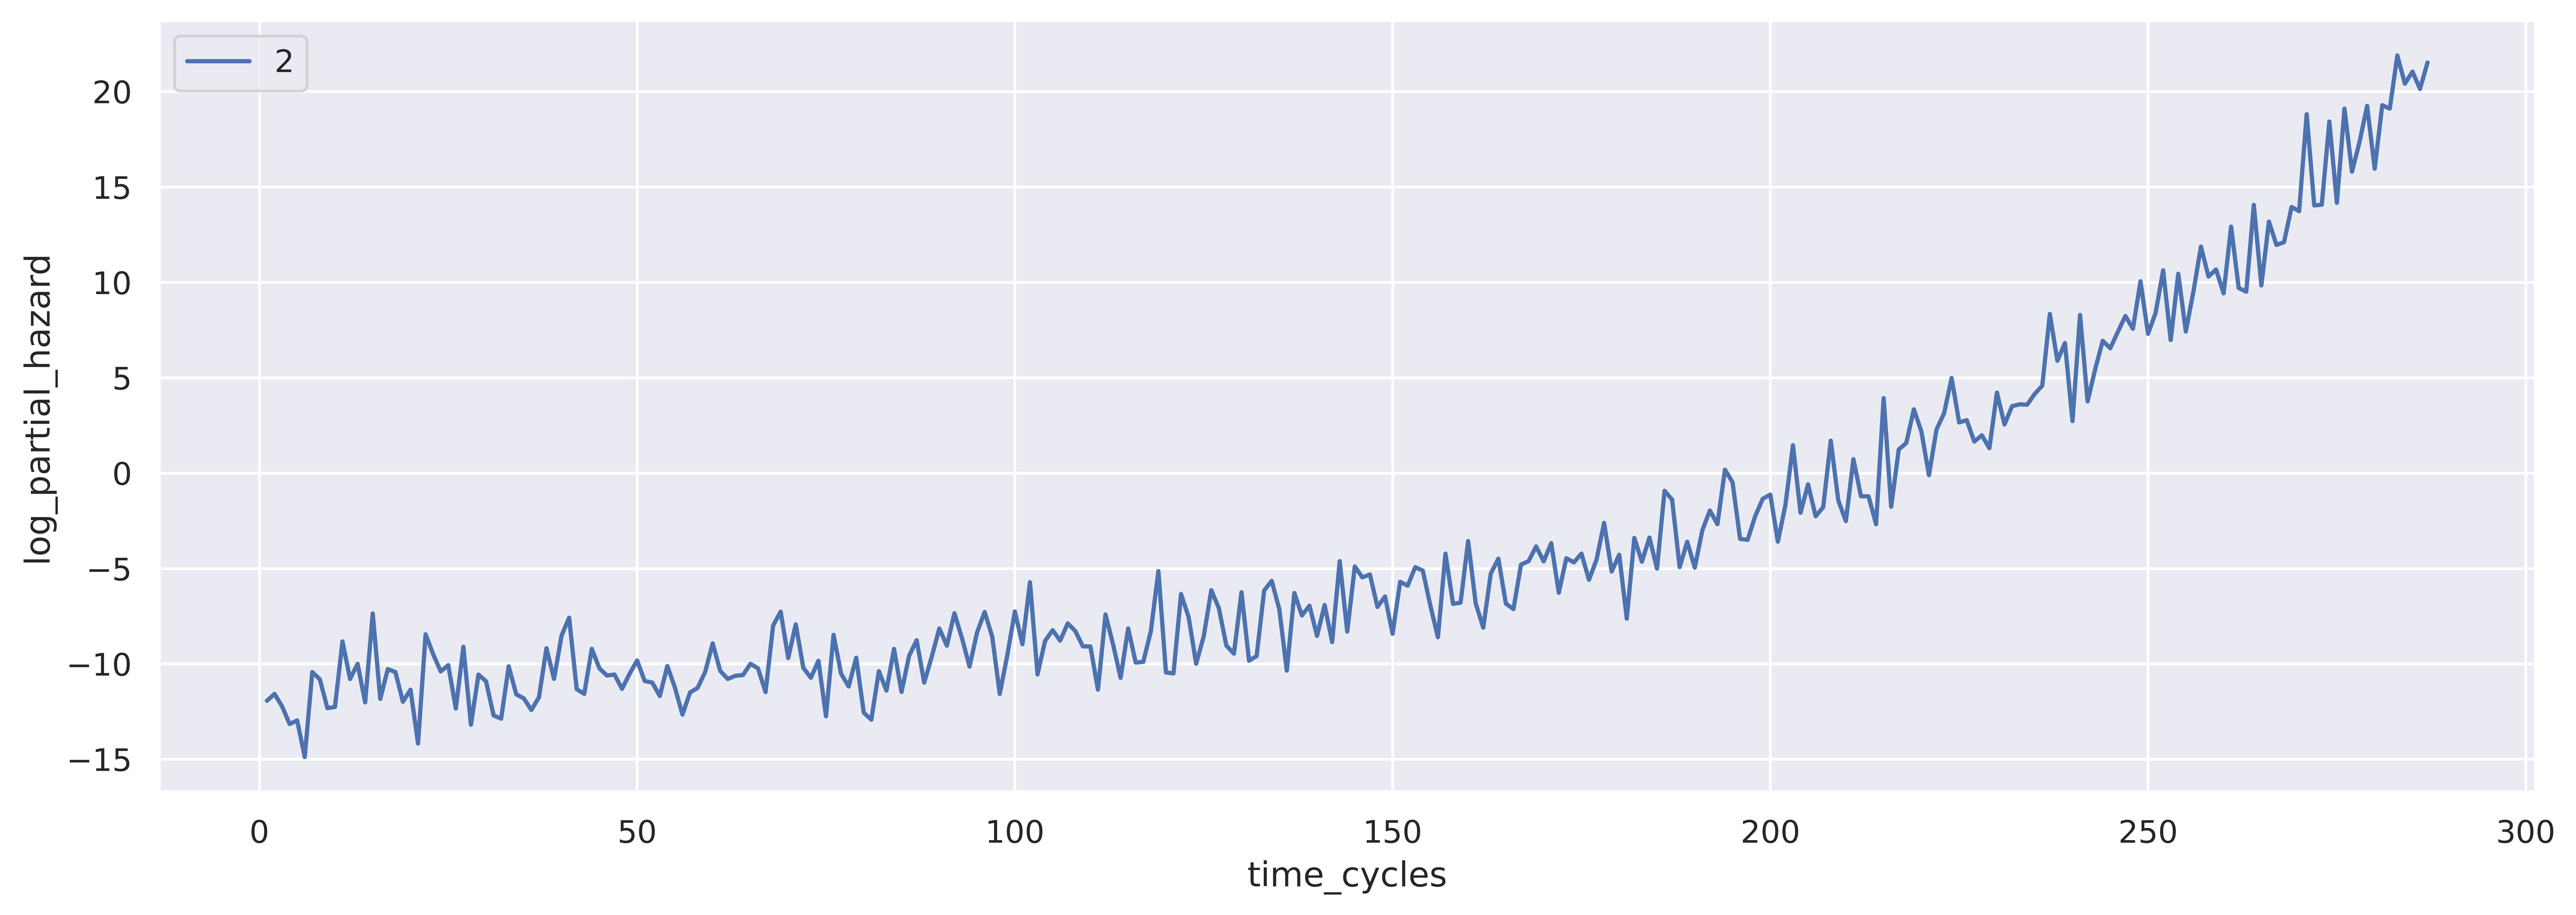

In [142]:
X = train_with_target.loc[train_with_target['UnitNumber'].isin(test_df.index)]
X['CycleStart'] = X['Cycle'] - 1
X_unique = len(X['UnitNumber'].unique())
unit_numbers = test_df.index.to_numpy()

plt.figure(figsize=(15,5), dpi=800)

for i in range(1):
    X_sub = X.loc[X['UnitNumber'] == unit_numbers[i]]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=unit_numbers[i])

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.legend()
plt.show()


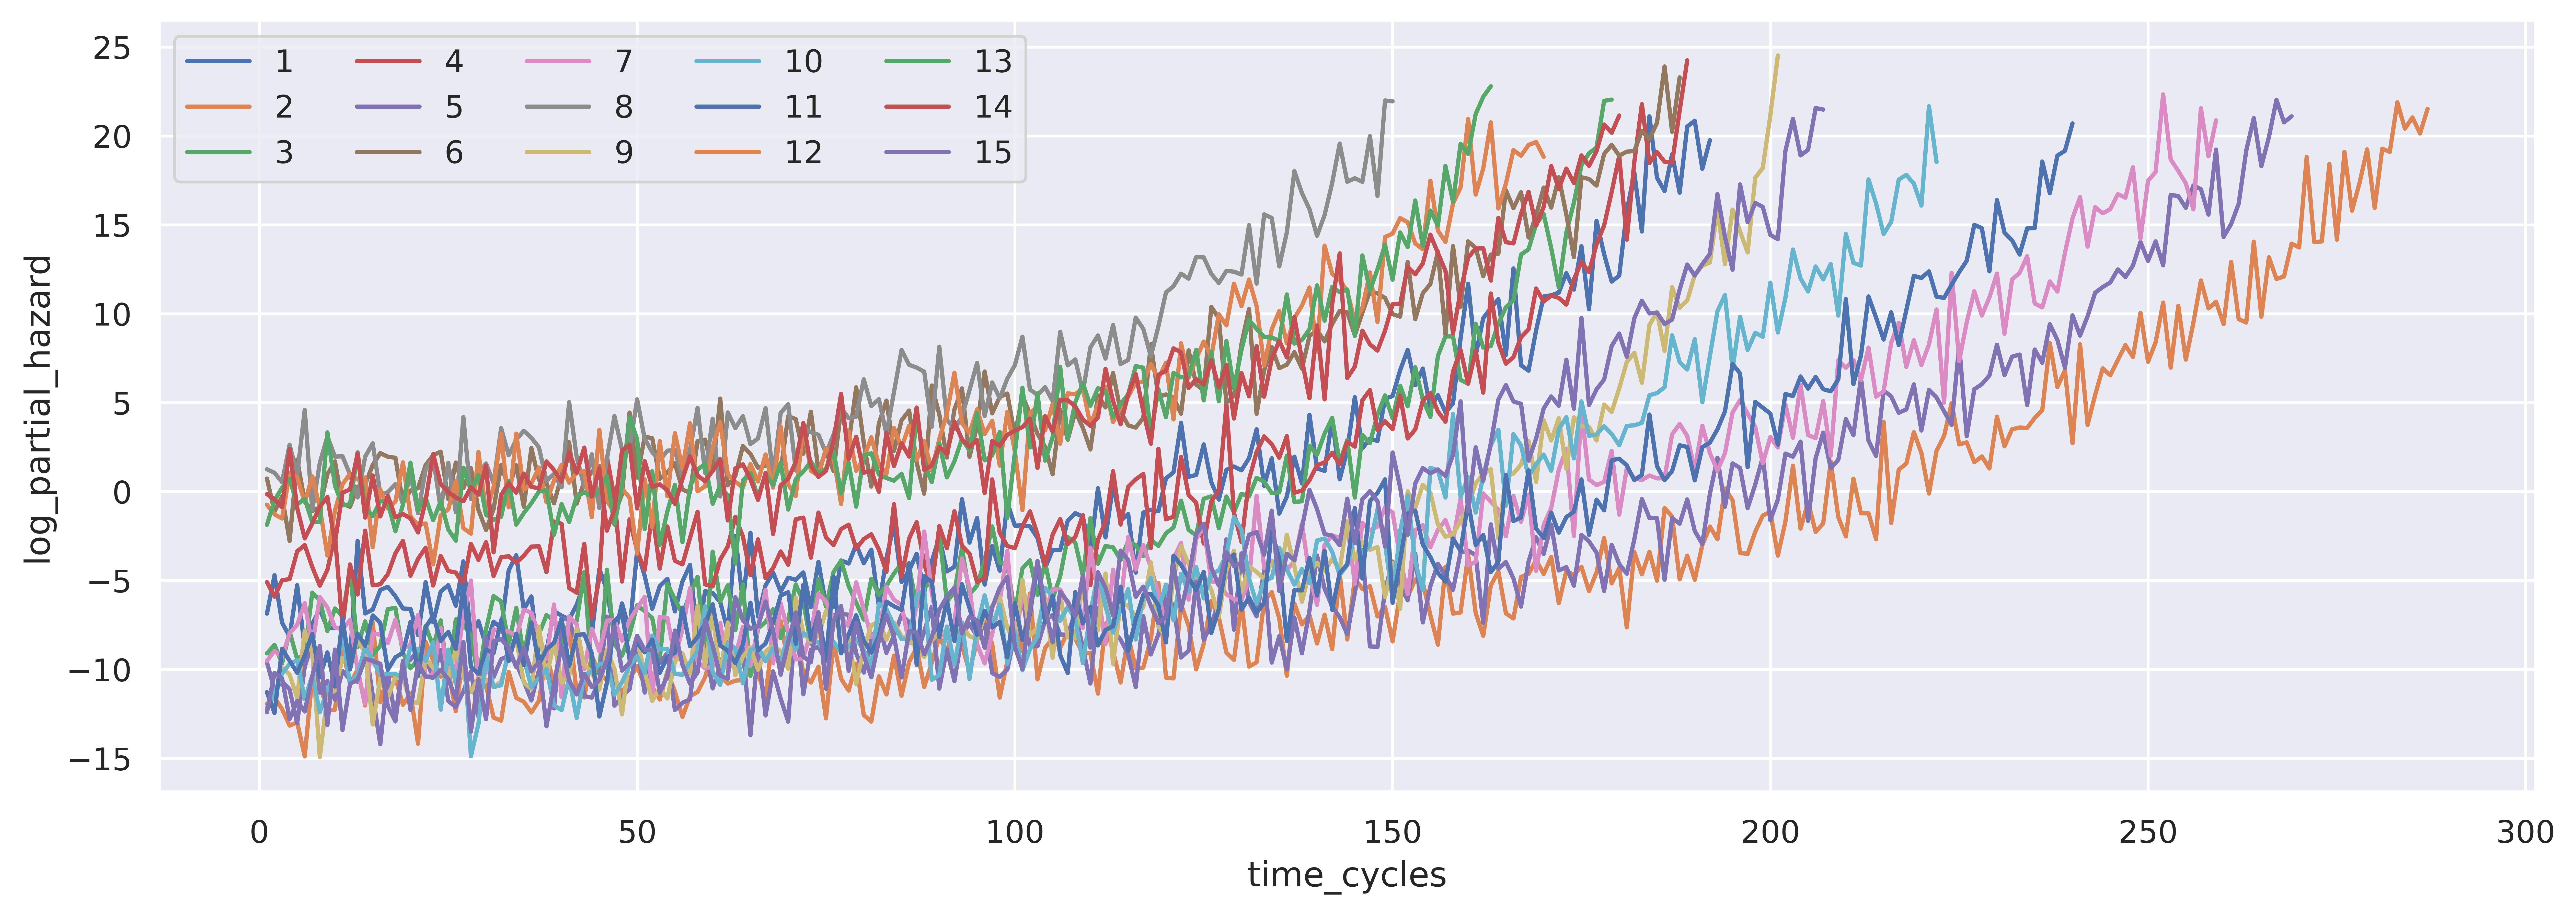

In [155]:
X = train_with_target
X['CycleStart'] = X['Cycle'] - 1

plt.figure(figsize=(15,5), dpi=800)

for i in range(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()
